In [31]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


file_path_df_035_join = r'C:\Users\sebas\OneDrive\Documenten\GitHub\Supermarketcasegroupproject\Group4B\data\interim\df_035_join.parquet'


df_aggregated_sales = pd.read_parquet(file_path_df_035_join)

df_aggregated_sales['date'] = pd.to_datetime(df_aggregated_sales[['month', 'year']].assign(DAY=1))


In [32]:
#df_aggregated_sales1 = df_aggregated_sales[(df_aggregated_sales['store_nbr'] == 1)&df_aggregated_sales([df_aggregated_sales['date'] == '2013-01-01')]
df_aggregated_sales1 = df_aggregated_sales[(df_aggregated_sales['store_nbr'] == 1) & (df_aggregated_sales['date'] == '2013-01-01')]

#df [ ( df['store_nbr'] == 25 ) & (df['day'] == 1) & (df['month'] == 1) & (df['year'] == 2013) ] .shape[0]

df_aggregated_sales1.head(1000)



,month,year,store_nbr,item_nbr,unit_sales,onpromotion_month_count,family,class,perishable,city,state,type,cluster,date
0,1,2013,1,96995,9.0,0,GROCERY I,1093,0,Quito,Pichincha,D,13,2013-01-01
1,1,2013,1,103520,61.0,0,GROCERY I,1028,0,Quito,Pichincha,D,13,2013-01-01
2,1,2013,1,103665,80.0,0,BREAD/BAKERY,2712,1,Quito,Pichincha,D,13,2013-01-01
3,1,2013,1,105574,149.0,0,GROCERY I,1045,0,Quito,Pichincha,D,13,2013-01-01
4,1,2013,1,105575,236.0,0,GROCERY I,1045,0,Quito,Pichincha,D,13,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,2013,1,876663,138.0,0,GROCERY I,1004,0,Quito,Pichincha,D,13,2013-01-01
996,1,2013,1,877513,238.0,0,CLEANING,3020,0,Quito,Pichincha,D,13,2013-01-01
997,1,2013,1,877514,174.0,0,CLEANING,3020,0,Quito,Pichincha,D,13,2013-01-01
998,1,2013,1,878715,17.0,0,GROCERY I,1040,0,Quito,Pichincha,D,13,2013-01-01


In [33]:
df_aggregated_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5813304 entries, 0 to 5813303
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   month                    int32         
 1   year                     int32         
 2   store_nbr                uint8         
 3   item_nbr                 uint32        
 4   unit_sales               float32       
 5   onpromotion_month_count  Int64         
 6   family                   category      
 7   class                    uint16        
 8   perishable               uint8         
 9   city                     category      
 10  state                    category      
 11  type                     category      
 12  cluster                  uint8         
 13  date                     datetime64[ns]
dtypes: Int64(1), category(4), datetime64[ns](1), float32(1), int32(2), uint16(1), uint32(1), uint8(3)
memory usage: 232.9 MB


In [34]:
df_aggregated_sales_store = df_aggregated_sales.groupby(['store_nbr', 'date','year']).agg({
                                'type': 'first', 
                                'cluster': 'first', 
                                'city': 'first', 
                                'state': 'first',
                                'unit_sales': 'sum'}).reset_index()
df_aggregated_sales_store

,store_nbr,date,year,type,cluster,city,state,unit_sales
0,1,2013-01-01,2013,D,13,Quito,Pichincha,156864.203125
1,1,2013-02-01,2013,D,13,Quito,Pichincha,129814.328125
2,1,2013-03-01,2013,D,13,Quito,Pichincha,151666.234375
3,1,2013-04-01,2013,D,13,Quito,Pichincha,155848.500000
4,1,2013-05-01,2013,D,13,Quito,Pichincha,154965.656250
...,...,...,...,...,...,...,...,...
2796,54,2017-04-01,2017,C,3,El Carmen,Manabi,249150.234375
2797,54,2017-05-01,2017,C,3,El Carmen,Manabi,310449.156250
2798,54,2017-06-01,2017,C,3,El Carmen,Manabi,309418.968750
2799,54,2017-07-01,2017,C,3,El Carmen,Manabi,317741.906250


## Step 2.1 - Total sales in units is generated by 

When looking into the data, we first delved deeper into just the amount of stores per city. Here, we found that especially Quito is overrepresented by the amount of supermarkets located there.

In [35]:
df_aggregated_sales_type = df_aggregated_sales.groupby('type')['unit_sales'].sum()/1000

df_aggregated_sales_type = df_aggregated_sales_type.sort_values(ascending=False)

df_aggregated_sales_type2 = pd.DataFrame(df_aggregated_sales_type)

df_aggregated_sales_type2['Percentage'] = df_aggregated_sales_type2/df_aggregated_sales_type2.sum()*100

df_aggregated_sales_type2 = round(df_aggregated_sales_type2,2)

df_aggregated_sales_type2


C:\Users\sebas\AppData\Local\Temp\ipykernel_35108\131753800.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aggregated_sales_type = df_aggregated_sales.groupby('type')['unit_sales'].sum()/1000


,unit_sales,Percentage
type,,
A,353043.812500,32.880001
D,351063.312500,32.700001
C,164434.453125,15.320000
B,145248.250000,13.530000
E,59820.421875,5.570000


## Step 2.1 - Total sales per store by month over all time periods in the dataset - Some stores are relatively new and might be excluded for further analysis

The first step we take when combining the store data with the transaction date is to look if there's unit sale data for each store available. Although we have data available for each store, some stores don't have data for all the dates in the dataset. Most likely, these stores are new, this makes forecasting for these store less convenient and as this is our first forecast for Corporacion Favorita, we rather have a more generalizable store to choose from (having a higher impact on business as the likelihood of giving a more accurate forecast is higher).

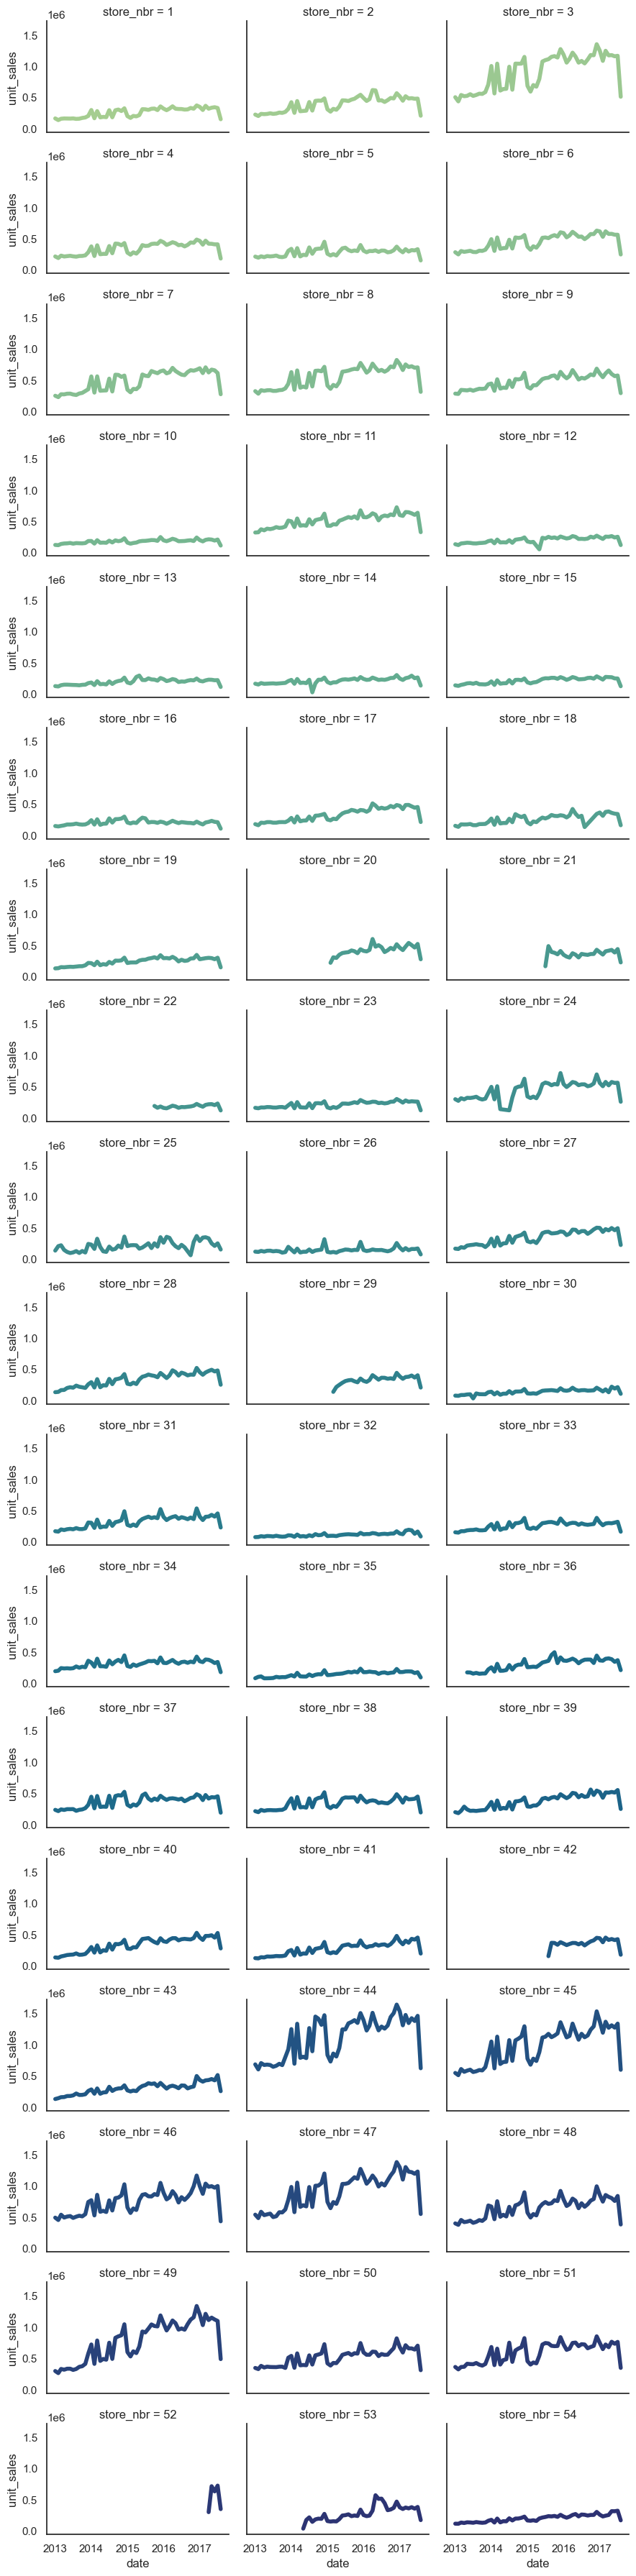

In [36]:
sns.set_theme(style="white")

g = sns.relplot(
    data=df_aggregated_sales_store,
    x="date", y="unit_sales", col="store_nbr", hue="store_nbr",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

## Step 2.1 - Total sales per store by month over all time periods in the dataset - It seems not only new stores miss data but also older stores have missing data

The only way to really check if stores have data for all the months in the dataset is to count the amount of months available of data. Thereby we find that 12 stores don't have data for the full timeperiod. 

Stores that are relatively new:

Started in 2013
Store 36 (per May)

Started in 2014
Store 53 (per May)

Started in 2015
Store 20 (per Feb)
Store 21 (per Jul)
Store 22 (per Oct)
Store 29 (per Mar)
Store 42 (per Aug)

Started in 2017
Store 52 (per Apr)

Stores that have missing data (might be closed for one or multiple months)

2014 - Store number 24
2015 - Store number 12
2016 - Store number 18 and 25



In [37]:
row_count_per_store = df_aggregated_sales_store['store_nbr'].value_counts()

row_count_per_store = row_count_per_store.sort_values(ascending=True)

print(row_count_per_store)

type(row_count_per_store)

store_nbr
52     5
22    23
42    25
21    26
29    30
20    31
53    40
36    52
18    53
24    54
25    55
12    55
4     56
5     56
6     56
7     56
8     56
9     56
16    56
11    56
14    56
54    56
3     56
19    56
23    56
10    56
17    56
1     56
28    56
26    56
2     56
30    56
31    56
32    56
33    56
34    56
35    56
37    56
38    56
39    56
40    56
41    56
43    56
44    56
45    56
46    56
47    56
48    56
49    56
50    56
51    56
27    56
13    56
15    56
Name: count, dtype: int64


pandas.core.series.Series

In [110]:
row_count_per_store56 = row_count_per_store[row_count_per_store == 56]
row_count_per_store56

<class 'pandas.core.series.Series'>
Index: 42 entries, 4 to 15
Series name: count
Non-Null Count  Dtype
--------------  -----
42 non-null     int64
dtypes: int64(1)
memory usage: 378.0 bytes


<Axes: xlabel='date'>

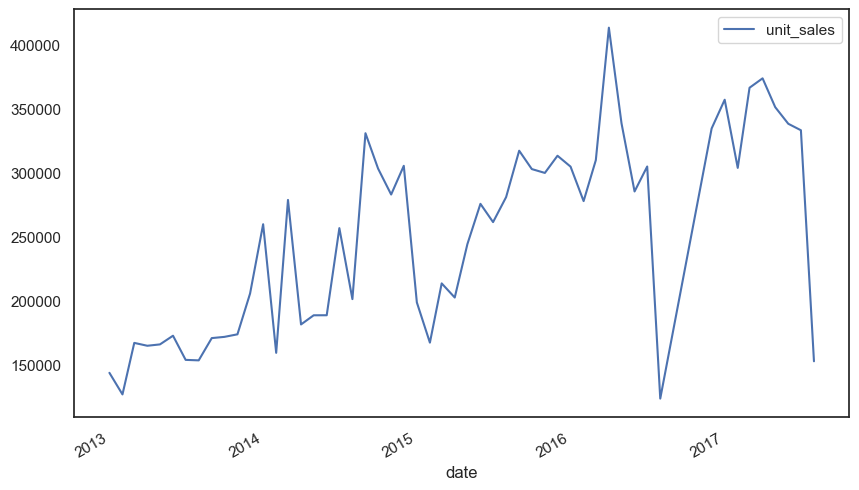

In [39]:
sns.set_theme(style="white")

df_store_25 = df_aggregated_sales_store[df_aggregated_sales_store['store_nbr'] == 18]
df_store_25.plot.line(x='date', y='unit_sales', figsize=(10, 6))

#df_store_25_filtered = df_store_25[df_store_25['unit_sales'] <= 1000]
#df_store_25_filtered.plot.line(x='date', y='unit_sales', figsize=(10, 6))

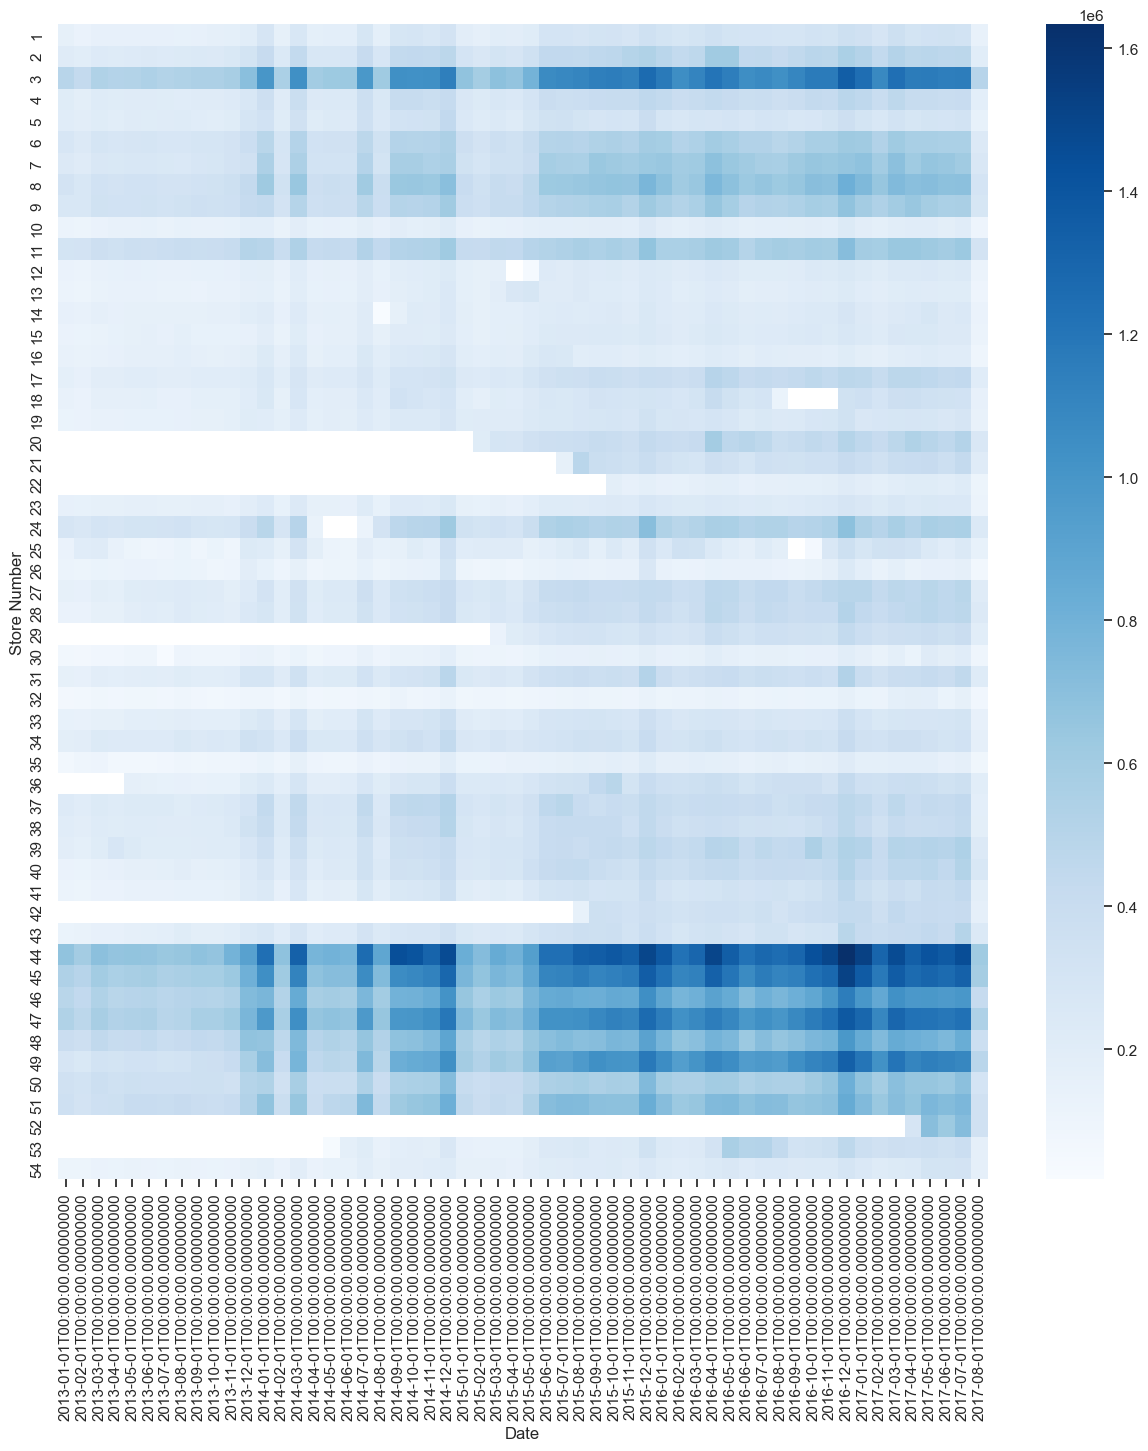

In [40]:
sns.set_theme(style="white")

# Pivot the dataframe to have store_nbr as rows, date as columns, and unit_sales as values
pivot_df = df_aggregated_sales_store.pivot(index='store_nbr', columns='date', values='unit_sales')

# Set the size of the figure
plt.figure(figsize=(15, 15))

# Create the heatmap
heatmapdatestoresales = sns.heatmap(pivot_df, cmap='Blues', annot=False, fmt='.1f')

# Set the labels for x and y axis
plt.xlabel('Date')
plt.ylabel('Store Number')

heatmapdatestoresales.xaxis.tick_bottom()

# Show the plot
plt.show()


From the heatmap we can atleast observe two things. First, we can see the several stores that are missing data. Second, we can see that several stores have significant higher sales in terms of units sold (store 3 and 44,45,46,47,48,49). Now, we can delve further into seeing wether the missing data influences the type and clusters of stores by comparing the original data to a filtered dataset.

## Step 2.2 - For investigating the types and clusters further, we drop the stores that don't have data for the full timeline.

In that way, we don't have to worry about these stores interfering with the results on any insights of type and cluster. However, to see if the missing data actually has an effect on the clusters and types, we first will make a boxplot on botht he original data (without filtering) as well as a filtered set.

Within the boxplot one can see the range of total unit_sales per cluster (a range determined by the unit sales per store within the cluster).

<function matplotlib.pyplot.show(close=None, block=None)>

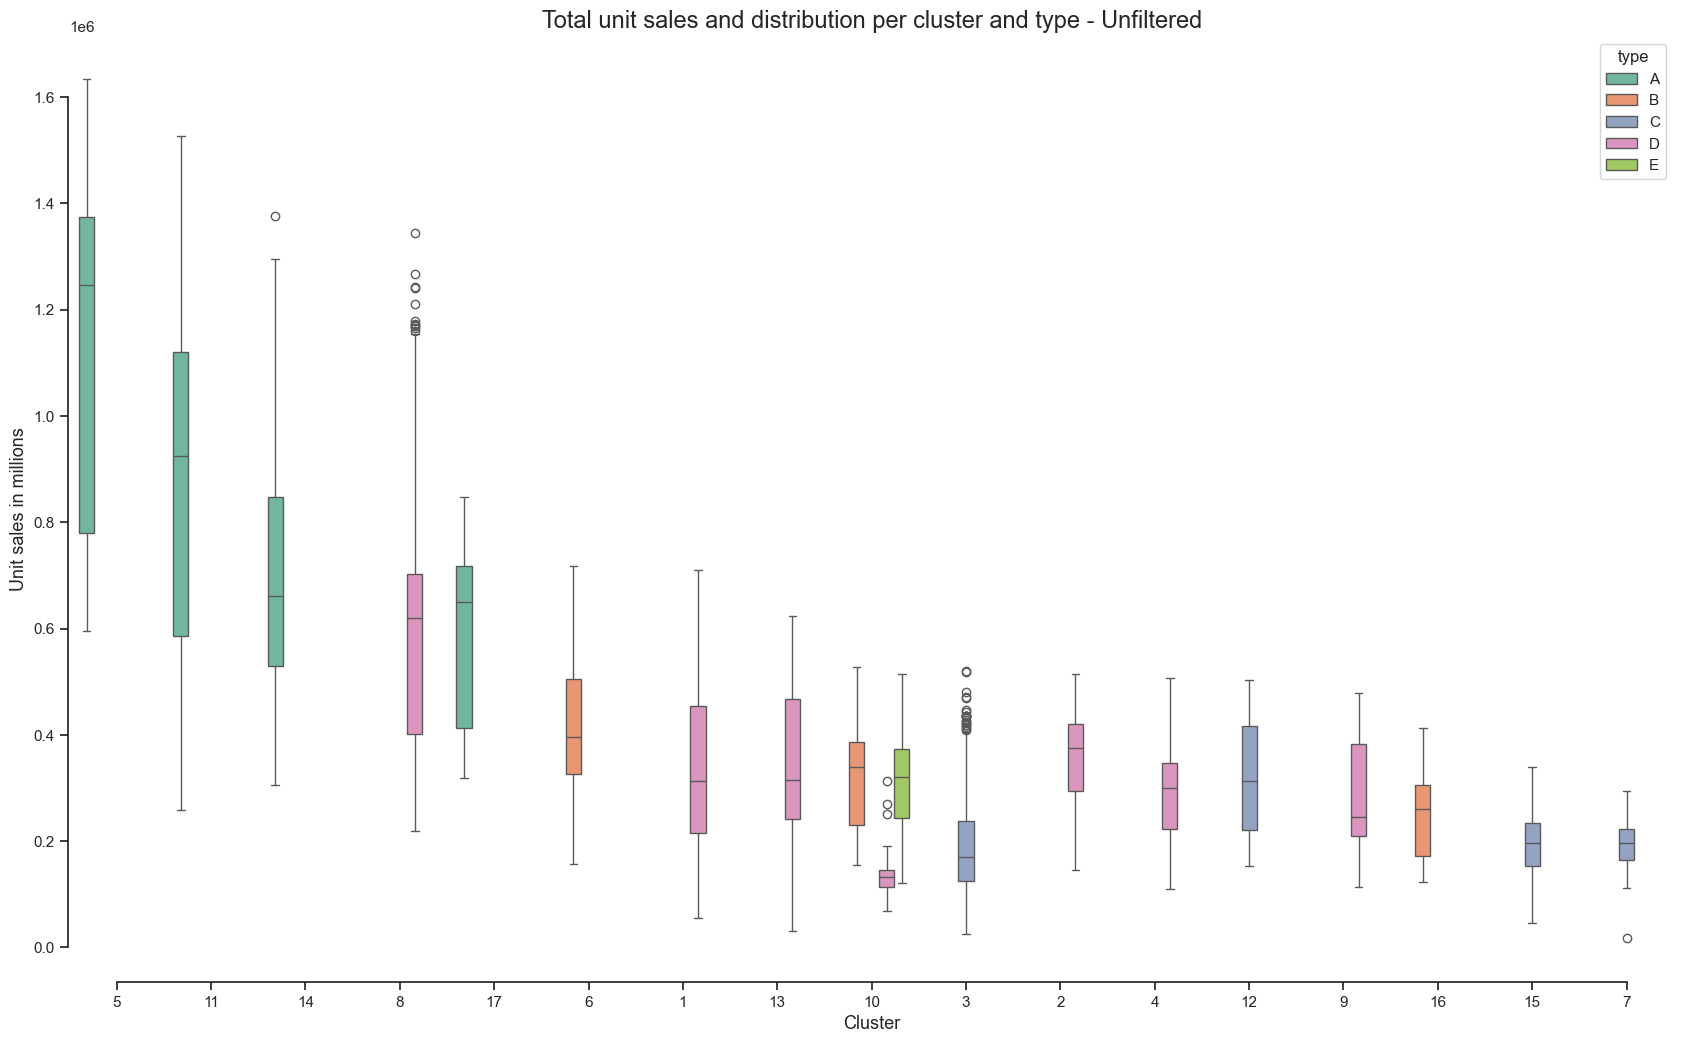

In [41]:
#First boxplot is made on the original data (not the filtered)
sns.set_theme(style="ticks", palette="rocket")

# Here i make a order list
order = df_aggregated_sales_store.groupby(['cluster'])['unit_sales'].max().sort_values(ascending=False).index

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="cluster", y="unit_sales",
            hue="type",palette='Set2',
            data=df_aggregated_sales_store,
            order=order).set_title("Total unit sales and distribution per cluster and type - Unfiltered", fontsize=17)
plt.ylabel("Unit sales in millions", fontsize=13)
plt.xlabel("Cluster", fontsize=13)
sns.despine(offset=1, trim=True)
sns.stripplot(dodge = True)
plt.show

In [42]:
df_aggregated_sales_store.shape

(2801, 8)

In [43]:
df_aggregated_sales_store_filtered = df_aggregated_sales_store.merge(row_count_per_store56.astype(df_aggregated_sales_store['store_nbr'].dtype), left_on= 'store_nbr', right_index=True, how='inner')

df_aggregated_sales_store_filtered.shape

(2352, 9)

In [44]:
df_aggregated_sales_store_filtered.head()

,store_nbr,date,year,type,cluster,city,state,unit_sales,count
0,1,2013-01-01,2013,D,13,Quito,Pichincha,156864.203125,56
1,1,2013-02-01,2013,D,13,Quito,Pichincha,129814.328125,56
2,1,2013-03-01,2013,D,13,Quito,Pichincha,151666.234375,56
3,1,2013-04-01,2013,D,13,Quito,Pichincha,155848.500000,56
4,1,2013-05-01,2013,D,13,Quito,Pichincha,154965.656250,56


Text(0.5, 0, 'Cluster')

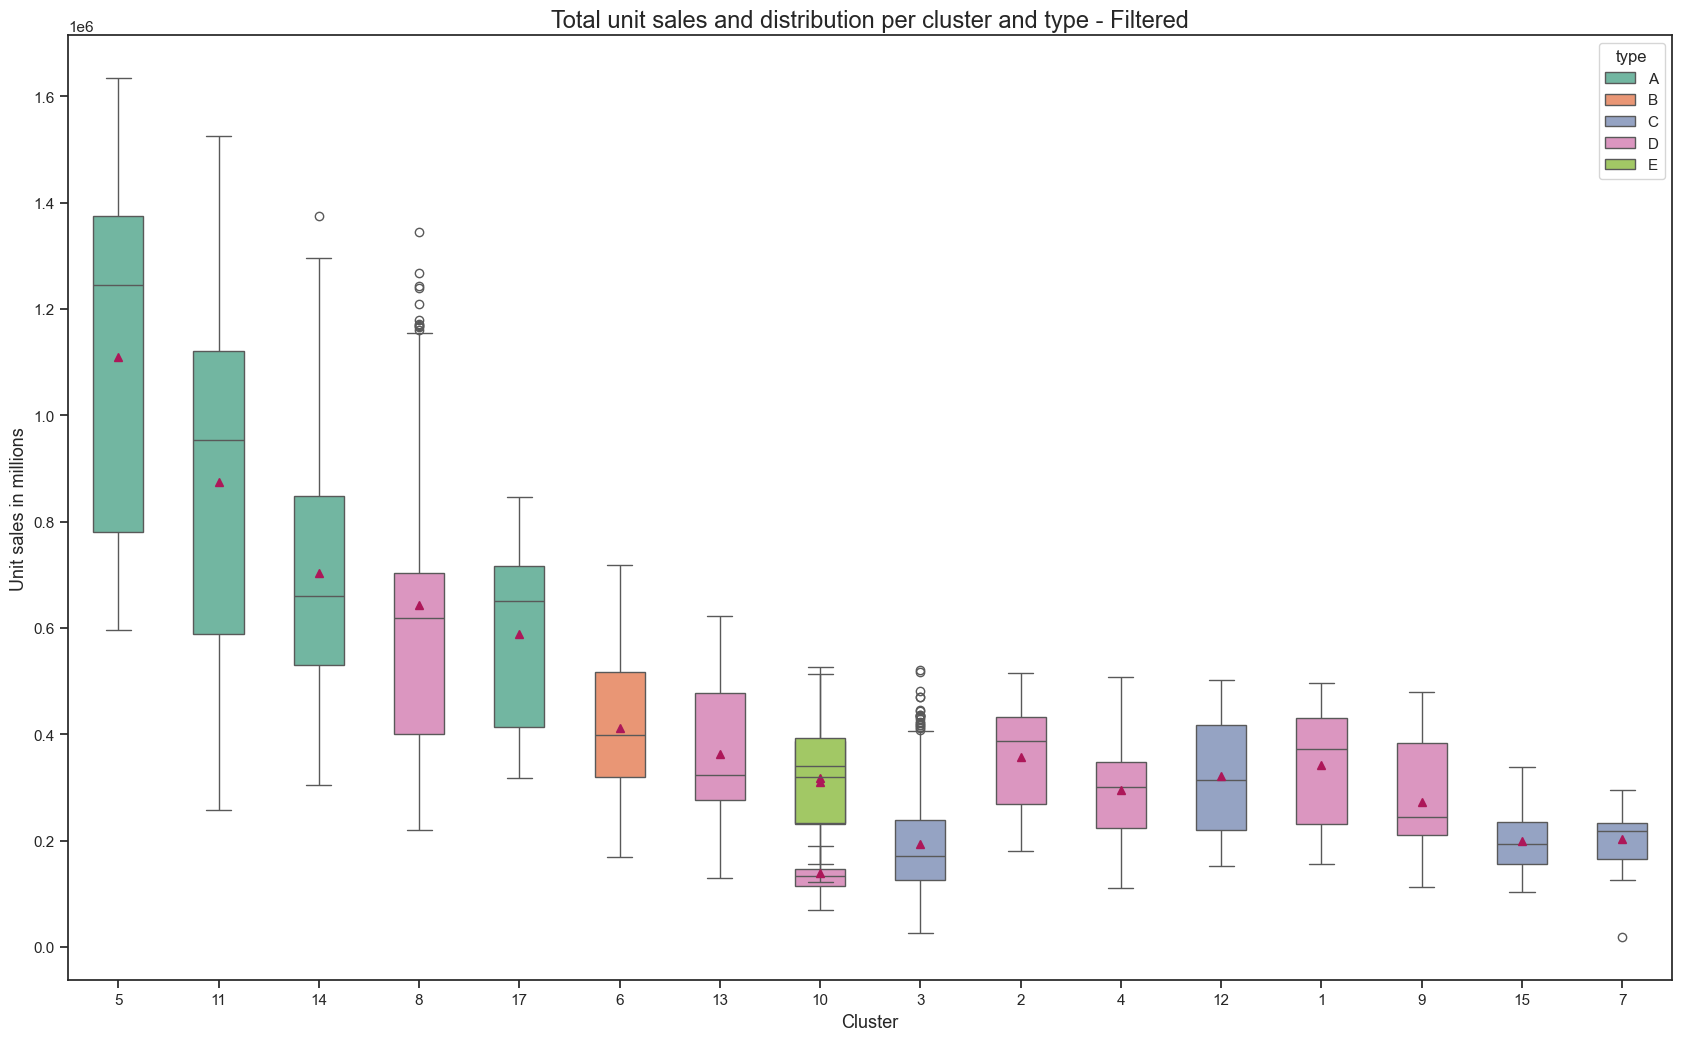

In [45]:
#Second boxplot is made on the filtered data
sns.set_theme(style="ticks", palette="rocket")

# Here i make a order list
order = df_aggregated_sales_store_filtered.groupby(['cluster'])['unit_sales'].max().sort_values(ascending=False).index

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="cluster", y="unit_sales",
            hue="type",palette='Set2',
            data=df_aggregated_sales_store_filtered,
            order=order,
            width=0.5,
            dodge=False,
            showmeans= True).set_title("Total unit sales and distribution per cluster and type - Filtered", fontsize=17)
plt.ylabel("Unit sales in millions", fontsize=13)
plt.xlabel("Cluster", fontsize=13)

To do

1- Average sales per city?
2- Sales per store (with color for city?)
3- 

In [46]:
df_aggregated_sales_store_filtered

,store_nbr,date,year,type,cluster,city,state,unit_sales,count
0,1,2013-01-01,2013,D,13,Quito,Pichincha,156864.203125,56
1,1,2013-02-01,2013,D,13,Quito,Pichincha,129814.328125,56
2,1,2013-03-01,2013,D,13,Quito,Pichincha,151666.234375,56
3,1,2013-04-01,2013,D,13,Quito,Pichincha,155848.500000,56
4,1,2013-05-01,2013,D,13,Quito,Pichincha,154965.656250,56
...,...,...,...,...,...,...,...,...,...
2796,54,2017-04-01,2017,C,3,El Carmen,Manabi,249150.234375,56
2797,54,2017-05-01,2017,C,3,El Carmen,Manabi,310449.156250,56
2798,54,2017-06-01,2017,C,3,El Carmen,Manabi,309418.968750,56
2799,54,2017-07-01,2017,C,3,El Carmen,Manabi,317741.906250,56


In [47]:
df_aggregated_sales_store_filtered_sum = df_aggregated_sales_store_filtered.groupby(['store_nbr',]).agg({
    'city' :'first',
    'state':'first',
    'type':'first',
    'unit_sales' : 'sum'}).reset_index()
df_aggregated_sales_store_filtered_sum = df_aggregated_sales_store_filtered_sum.astype({'store_nbr':str})

df_aggregated_sales_store_filtered_sum

,store_nbr,city,state,type,unit_sales
0,1,Quito,Pichincha,D,14145012.0
1,2,Quito,Pichincha,D,21554618.0
2,3,Quito,Pichincha,D,50481900.0
3,4,Quito,Pichincha,D,18909698.0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,15592405.0
5,6,Quito,Pichincha,D,25183678.0
6,7,Quito,Pichincha,D,26952020.0
7,8,Quito,Pichincha,D,30491336.0
8,9,Quito,Pichincha,B,26409398.0
9,10,Quito,Pichincha,C,9613906.0


In [48]:
# Sort the dataframe to unit_sales
df_aggregated_sales_store_filtered_sum =df_aggregated_sales_store_filtered_sum.sort_values(by = 'unit_sales', ascending=False)


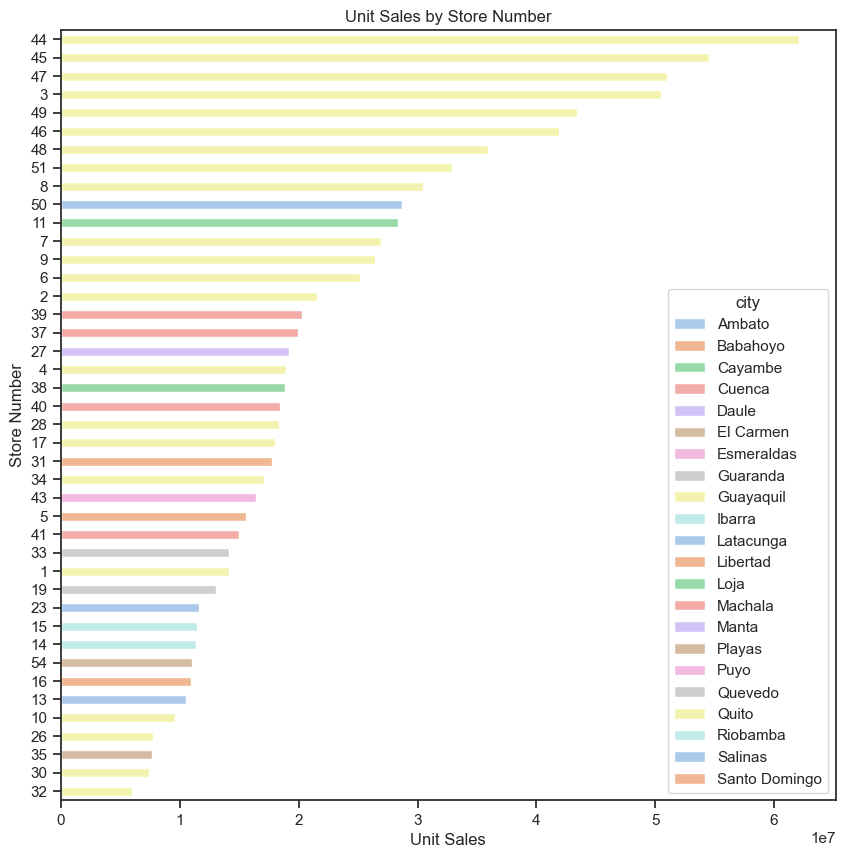

In [49]:

# Set the figure size
plt.figure(figsize=(10, 10))  # Adjust the width and height as desired

# Create the barplot
sns.barplot(data=df_aggregated_sales_store_filtered_sum, x='unit_sales', y='store_nbr', hue='city', palette='pastel', width = 0.5)

# Set the title and labels
plt.title('Unit Sales by Store Number')
plt.xlabel('Unit Sales')
plt.ylabel('Store Number')

# Show the plot
plt.show()

<Axes: xlabel='city', ylabel='store_nbr'>

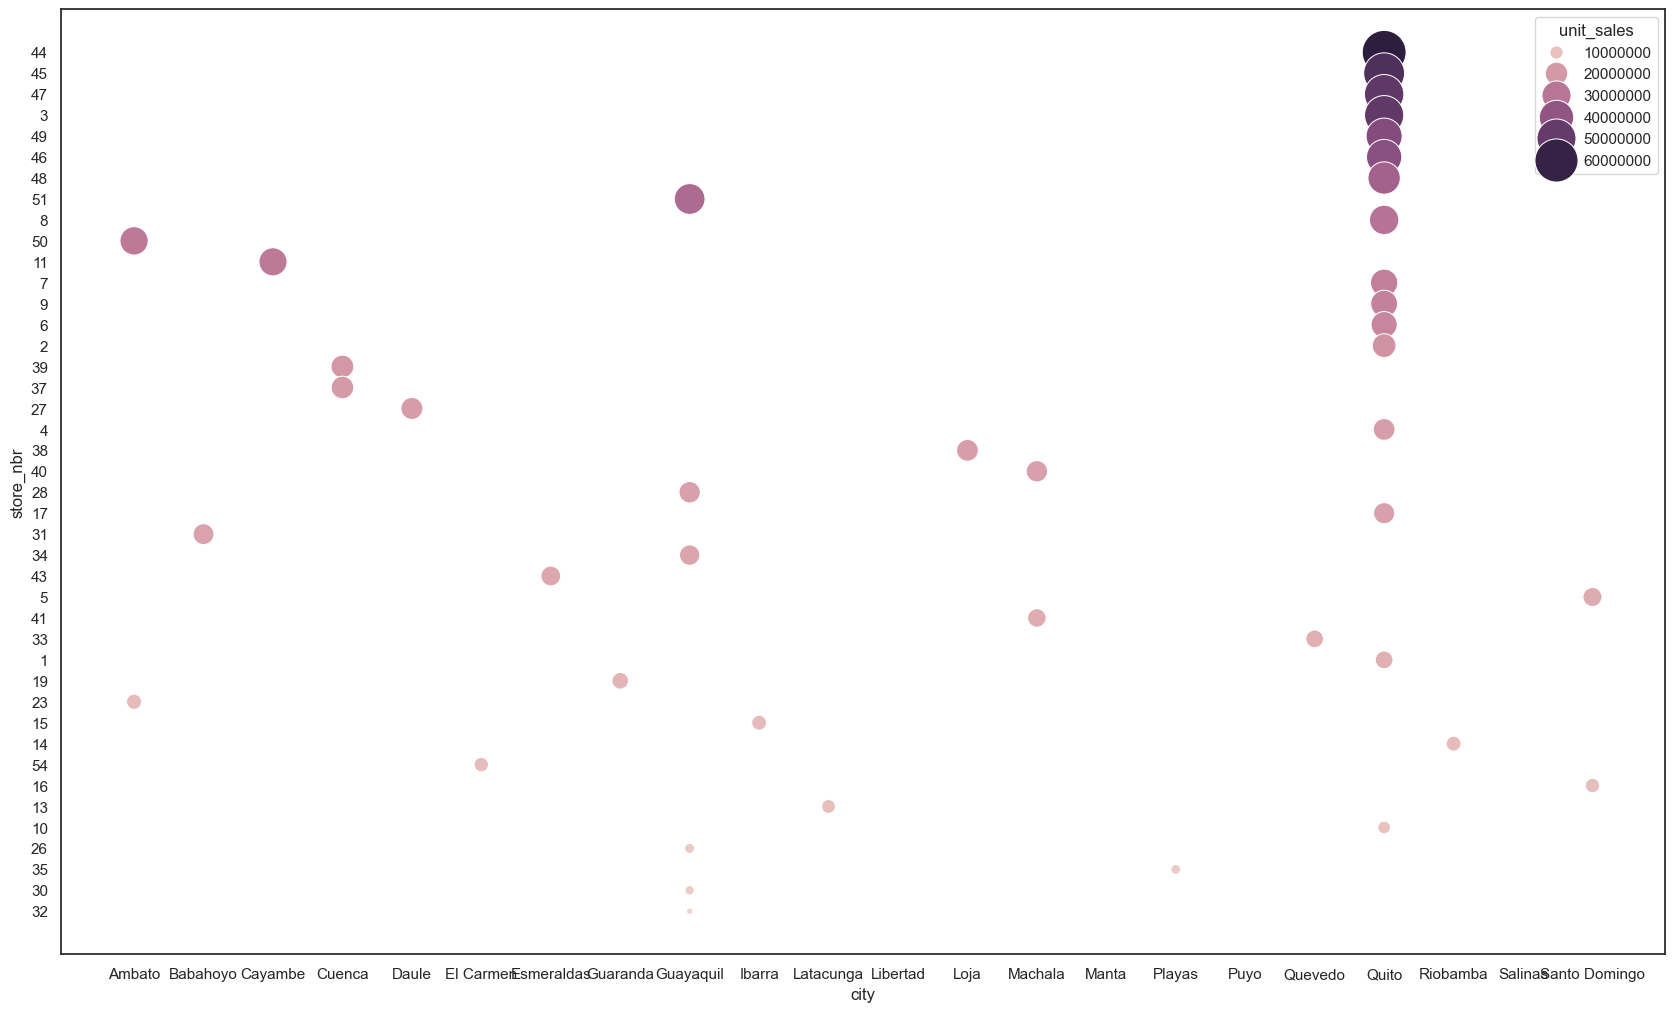

In [50]:
sns.set_theme(rc={'figure.figsize':(20.7,12.27)},style="white", palette=None)
sns.scatterplot(
    data = df_aggregated_sales_store_filtered_sum, x="city", y='store_nbr', hue ='unit_sales', size = 'unit_sales',  
    sizes =(20,1000), legend = "brief"
)


In [52]:

# Calculate the percentage of unit_sales per store in relation to the total unit_sales
df_aggregated_sales_store_filtered_sum['Percentage'] = (df_aggregated_sales_store_filtered_sum['unit_sales'] / df_aggregated_sales_store_filtered_sum['unit_sales'].sum())*100

# Make a cumulative sum of the amount of stores
df_aggregated_sales_store_filtered_sum['Cum_sum'] = df_aggregated_sales_store_filtered_sum['unit_sales'].cumsum()

# Make a cumulative percentage column
df_aggregated_sales_store_filtered_sum['Cumulative Percentage'] = round(100*df_aggregated_sales_store_filtered_sum.Cum_sum/df_aggregated_sales_store_filtered_sum['unit_sales'].sum(),2)

df_aggregated_sales_store_filtered_sum.reset_index(drop=True, inplace=True)

df_aggregated_sales_store_filtered_sum

,store_nbr,city,state,type,unit_sales,Percentage,Cum_sum,Cumulative Percentage
0,44,Quito,Pichincha,A,62087544.0,6.602556,62087544.0,6.600000
1,45,Quito,Pichincha,A,54498012.0,5.795465,116585552.0,12.400000
2,47,Quito,Pichincha,A,50948308.0,5.417980,167533856.0,17.820000
3,3,Quito,Pichincha,D,50481900.0,5.368381,218015760.0,23.180000
4,49,Quito,Pichincha,A,43420088.0,4.617409,261435840.0,27.799999
5,46,Quito,Pichincha,A,41896052.0,4.455339,303331904.0,32.259998
6,48,Quito,Pichincha,A,35933132.0,3.821226,339265024.0,36.080002
7,51,Guayaquil,Guayas,A,32911484.0,3.499896,372176512.0,39.580002
8,8,Quito,Pichincha,D,30491336.0,3.242531,402667840.0,42.820000
9,50,Ambato,Tungurahua,A,28653018.0,3.047039,431320864.0,45.869999


## Step 2.3 - Find out of the stores that are filtered out have a big impact on sales units and thus alternative ways should be found

Although we filtered out the stores in the former steps, we have to find out if filtering out was the right decision to take. They might have a big impact on total sales and therefore excluding them might have not been the right decision to make. Therefore in this step i will analyse the impact of the stores with missing data on the total sales units.

Step 1 - Make a aggregated dataset for sales per store over the full timeline and mark the stores according to: 1) stores that have data available for all data points, 2) stores that miss a lot of data (started later), 3) stores that miss some data. 

Step 2 - Plot the relative size of sales of the combination of missing data categories 2 and 3 in relation to the total.

Step 3 - For new stores, also look into the last year/months of sales to see if they are relatively big (they might be new but exceptionally big. Thus, being important for further exploration).

In [ ]:
# Impact of new stores on total sales 
# What new stores might be interesting?
# Look at daily level sales data with stores to see if you can find interesting insights. 
# Oil price

In [73]:
# Step 1 - Make aggregated data set for sales per store over the full timeline and mark stores according to  1) stores that have data available for all data points, 2) stores that miss a lot of data (started later), 3) stores that miss some data. 

df_aggregated_sales_store_unfiltered = df_aggregated_sales_store.merge(row_count_per_store.astype(df_aggregated_sales_store['store_nbr'].dtype), left_on= 'store_nbr', right_index=True, how='inner')

# Rename the result of the count column to a monthcount (as it stands for monthcount)
df_aggregated_sales_store_unfiltered = df_aggregated_sales_store_unfiltered.rename(columns={'count':'monthcount'})

# Aggregate the dataframe on sales and store level from a month basis to a total basis
df_aggregated_sales_store_unfiltered_sum = df_aggregated_sales_store_unfiltered.groupby(['store_nbr','monthcount']).agg({
    'city' :'first',
    'state':'first',
    'type':'first',
    'unit_sales' : 'sum'}).reset_index()
df_aggregated_sales_store_unfiltered_sum = df_aggregated_sales_store_unfiltered_sum.astype({'store_nbr':str})

# Assign a value of 0 to the stores that have data available for all data points and 0 to the stores that miss data.
df_aggregated_sales_store_unfiltered_sum['store_status'] = np.where(df_aggregated_sales_store_unfiltered_sum['monthcount'] == 56, 0, 1)
df_aggregated_sales_store_unfiltered_sum['dummy'] = 1

df_aggregated_sales_store_unfiltered_sum

,store_nbr,monthcount,city,state,type,unit_sales,store_status,dummy
0,1,56,Quito,Pichincha,D,14145012.00,0,1
1,2,56,Quito,Pichincha,D,21554618.00,0,1
2,3,56,Quito,Pichincha,D,50481900.00,0,1
3,4,56,Quito,Pichincha,D,18909698.00,0,1
4,5,56,Santo Domingo,Santo Domingo de los Tsachilas,D,15592405.00,0,1
5,6,56,Quito,Pichincha,D,25183678.00,0,1
6,7,56,Quito,Pichincha,D,26952020.00,0,1
7,8,56,Quito,Pichincha,D,30491336.00,0,1
8,9,56,Quito,Pichincha,B,26409398.00,0,1
9,10,56,Quito,Pichincha,C,9613906.00,0,1


In [81]:
# Step 2 - Plot the relative size of sales of the combination of missing data categories 2 and 3 in relation to the total.

alt.Chart(df_aggregated_sales_store_unfiltered_sum).mark_bar(size = 40).encode(
    x=alt.X('sum(unit_sales)').stack("normalize"),
    y='dummy',
    color='store_status'
)



c:\Users\sebas\OneDrive\Documenten\GitHub\Supermarketcasegroupproject\Group4B\.venv\lib\site-packages\altair\utils\core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [87]:
# Find out the real percentage of sales for both categories
df_aggregated_sales_store_unfiltered_storestatus_sum = df_aggregated_sales_store_unfiltered_sum.groupby(['store_status']).sum(['unit_sales']).reset_index()

df_aggregated_sales_store_unfiltered_storestatus_sum['Percentage'] = (df_aggregated_sales_store_unfiltered_storestatus_sum['unit_sales'] / df_aggregated_sales_store_unfiltered_storestatus_sum['unit_sales'].sum())*100

df_aggregated_sales_store_unfiltered_storestatus_sum

,store_status,monthcount,unit_sales,dummy,Percentage
0,0,2352,940356160.0,42,87.588219
1,1,449,133254128.0,12,12.411777


In [104]:
# Does this differ when we look at one of the last months of data?

df_aggregated_sales_store_july2017 = df_aggregated_sales_store[df_aggregated_sales_store['date'] == '2017-07-01']

df_aggregated_sales_store_july2017 = df_aggregated_sales_store_july2017[['store_nbr','unit_sales','date']]

df_aggregated_sales_store_july2017['store_nbr'] = df_aggregated_sales_store_july2017['store_nbr'].astype('str')

df_aggregated_sales_store_july2017_status = df_aggregated_sales_store_july2017.merge(df_aggregated_sales_store_unfiltered_sum[['store_nbr','store_status','dummy']].astype(df_aggregated_sales_store_july2017['store_nbr'].dtype), left_on='store_nbr',right_on= 'store_nbr', how='inner')

df_aggregated_sales_store_july2017_status

,store_nbr,unit_sales,date,store_status,dummy
0,1,3.239361e+05,2017-07-01,0,1
1,2,4.742919e+05,2017-07-01,0,1
2,3,1.159554e+06,2017-07-01,0,1
3,4,4.031534e+05,2017-07-01,0,1
4,5,3.256469e+05,2017-07-01,0,1
5,6,5.568297e+05,2017-07-01,0,1
6,7,6.050179e+05,2017-07-01,0,1
7,8,6.959551e+05,2017-07-01,0,1
8,9,5.659554e+05,2017-07-01,0,1
9,10,2.019139e+05,2017-07-01,0,1


In [107]:
df_aggregated_sales_store_july2017_status_grouped = df_aggregated_sales_store_july2017_status.groupby('store_status').sum('unit_sales')

df_aggregated_sales_store_july2017_status_grouped['Percentage'] = (df_aggregated_sales_store_july2017_status_grouped['unit_sales']/df_aggregated_sales_store_july2017_status_grouped['unit_sales'].sum())*100

df_aggregated_sales_store_july2017_status_grouped

,unit_sales,Percentage
store_status,,
0,22187028.0,82.139275
1,4824446.0,17.860729
